<a href="https://colab.research.google.com/github/itaywasser/final_project/blob/main/2024_final_project_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
#!pip install -q monai

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-208us42p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-208us42p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=765ee82fd38d38e98b827b26b6e049132e4261840188f7bfa06c04e7086326fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-gts8zx1d/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from datasets import Dataset as DS
import torch
import albumentations as A
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from skimage import filters
import cv2

load dataset

In [ ]:
def create_dataset(id_list, path):
  data_list = [load_data(id, path) for id in id_list]
  imgs, masks = zip(*data_list)
  dataset_dict = {
      "image": list(imgs),
      "mask": list(masks),
      "id":   id_list,
  }
  return DS.from_dict(dataset_dict).with_format("np")

In [ ]:
def load_data(id, path):
  data_path = os.path.join(path, str(id))
  img = np.load(os.path.join(data_path, "image.npy")).astype(np.uint8)
  mask = np.load(os.path.join(data_path, "mask.npy"))
  return img, mask

In [ ]:
train_data_path = r''

train_id, val_id = train_test_split(os.listdir(train_data_path), test_size=0.1766)

train_dataset = create_dataset(train_id, train_data_path)
val_dataset = create_dataset(val_id, train_data_path)

Get bounding boxes from masks.

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  #x_min = max(0, x_min - 30) # for train: x_min - np.random.randint(0, 20)
  #x_max = min(W, x_max + 30) # for train: x_max + np.random.randint(0, 20)
  #y_min = max(0, y_min - 30) # for train: y_min - np.random.randint(0, 20)
  #y_max = min(H, y_max + 30) # for train: y_max + np.random.randint(0, 20)
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

creating dataset class for the model

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor, augment=None, bbox=True, grid_size=25):
    self.dataset = dataset
    self.processor = processor
    self.augment = augment
    self.bbox = bbox
    self.grid_size = grid_size

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"].astype(np.uint8)
    ground_truth_mask = item["mask"]
    id = item["id"]

    if self.augment != None:
      augmented = self.augment(image=image, mask=ground_truth_mask.astype(np.uint8))
      image = augmented['image']
      ground_truth_mask = augmented['mask']

    image_rgb = Image.fromarray(image).convert("RGB")

    # prepare image and prompt for the model
    if self.bbox:
      # get bounding box prompt
      prompt = get_bounding_box(ground_truth_mask)
      inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")
    else:
      # get grid
      prompt = create_grid(ground_truth_mask.shape[0], self.grid_size)
      inputs = self.processor(image_rgb, input_points=prompt, return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add original image
    inputs["image"] = image_rgb

    # add ground truth segmentation
    inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask)

    # add the image id
    inputs["id"] = id

    return inputs

Initialize the processor

In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

 Create an instance of the SAMDataset for train and val

In [ ]:
augment = A.Resize(256, 256)
train_SAMdataset = SAMDataset(dataset=train_dataset, processor=processor, augment=augment)
val_SAMdataset = SAMDataset(dataset=val_dataset, processor=processor, augment=augment)

 Create a DataLoader instances for the training and validation datasets

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_SAMdataset, batch_size=2, shuffle=True, drop_last=False)
val_loader = DataLoader(val_SAMdataset, batch_size=2, shuffle=True, drop_last=False)

Load the model

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

make sure we only compute gradients for mask decoder

In [ ]:
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    print(name)
    param.requires_grad_(False)

Initialize the optimizer and the loss function

In [ ]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

training step

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader, loss_func):
    model.eval()
    val_losses = []
    for val_batch in val_loader:
      # forward pass
      outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                      input_boxes=val_batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = val_batch["ground_truth_mask"].float().to(device)
      val_loss = loss_func(predicted_masks, ground_truth_masks.unsqueeze(1))
      val_losses.append(val_loss.item())
    return mean(val_losses)

In [ ]:
from tqdm import tqdm
from statistics import mean

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_loader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      train_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      train_loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(train_loss.item())



    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'val loss: {evaluate(model, val_loader, loss_func=seg_loss)}')

save the model

In [ ]:
torch.save(model.state_dict(), "medSAm_finetune_model_checkpoint.pth")

##Test model

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("flaviagiammarino/medsam-vit-base")
medsam_processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

# Create an instance of the model architecture with the loaded configuration
model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
model.load_state_dict(torch.load("medSAm_finetune_model_checkpoint.pth"))

In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

config.json:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

###Creating test dataset

In [ ]:
test_data_path = r'/content/data DL test'

with ZipFile(test_data_path + ".zip", 'r') as zObject:
  zObject.extractall(path=test_data_path)

In [ ]:
test_dataset = create_dataset(os.listdir(test_data_path), test_data_path)


In [ ]:
test_dataset[0]

{'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'id': '46'}

In [ ]:
test_SAMdataset = SAMDataset(dataset=test_dataset, processor=processor)

In [ ]:
test_SAMdataset[0]

{'pixel_values': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'original_sizes': tensor([512, 512]),
 'reshaped_input_sizes': tensor([1024, 1024]),
 'input_boxes': tensor([[534., 352., 758., 504.]], dtype=torch.float64),
 'image': <PIL.

In [ ]:
def create_grid(image_size, grid_size):
    # Generate the grid points
    x = np.linspace(0, image_size-1, grid_size)
    y = np.linspace(0, image_size-1, grid_size)

    # Generate a grid of coordinates
    xv, yv = np.meshgrid(x, y)

    # Convert the numpy arrays to lists
    xv_list = xv.tolist()
    yv_list = yv.tolist()

    # Combine the x and y coordinates into a list of list of lists
    input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

    #We need to reshape our nxn grid to the expected shape of the input_points tensor
    # (batch_size, point_batch_size, num_points_per_image, 2),
    # where the last dimension of 2 represents the x and y coordinates of each point.
    #batch_size: The number of images you're processing at once.
    #point_batch_size: The number of point sets you have for each image.
    #num_points_per_image: The number of points in each set.
    input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

    return input_points

###testing

In [ ]:
from sklearn.metrics import f1_score, jaccard_score, recall_score, precision_score, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Ensure the tensors are on CPU and convert to numpy arrays
    y_true = y_true.flatten().astype('uint8')
    y_pred = y_pred.flatten().astype('uint8')

    # Compute F1 score and Jaccard index using scikit-learn
    f1 = f1_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)


    #add more metrics

    metrics = {
        'F1 Score': f1,
        'Jaccard Index': jaccard,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy
    }

    return metrics

In [ ]:
@torch.no_grad()
def Test(model, test_dataset, processor, threshold):
  metrics_list =  {
        'F1 Score': [],
        'Jaccard Index': [],
        'Recall': [],
        'Precision': [],
        'Accuracy': [],
        'id': []
    }
  for data in test_dataset:
    outputs = model(pixel_values=data["pixel_values"].unsqueeze(0).to(device),
                        input_boxes=data["input_boxes"].unsqueeze(0).to(device),
                        multimask_output=False)
    probs = processor.image_processor.post_process_masks(outputs.pred_masks.detach().cpu().sigmoid(), data["original_sizes"].unsqueeze(0), data["reshaped_input_sizes"].unsqueeze(0), binarize=False)
    pred_mask_pt = probs[0].squeeze((0,1))
    pred_mask = pred_mask_pt.numpy() > threshold


    gt_mask = data["ground_truth_mask"].detach().cpu().numpy()
    metrics = calculate_metrics(gt_mask, pred_mask)
    for k,v in metrics.items():
      metrics_list[k].append(v)

    metrics_list['id'].append( data["id"])
    plot_fun(data["image"], gt_mask, pred_mask, id = data["id"])

  return metrics_list

In [ ]:
def plot_fun(image, gt_mask, pred_mask, id):

  fig, axs = plt.subplots(2,2, figsize=(10,10))
  # plots the image
  axs[0,0].imshow(np.array(image))
  axs[0,0].set_title(f"Input Image: {id}")
  axs[0,0].axis("off")

  # plots the image and ground truth mask
  axs[0,1].imshow(np.array(image))
  axs[0,1].contour(gt_mask, [0], colors='r')
  axs[0,1].set_title("Input Image and ground truth mask")
  axs[0,1].axis("off")

 # plots the image and MEDSAM segmentation
  axs[1,0].imshow(np.array(image))
  axs[1,0].contour(pred_mask, [0], colors='r')
  axs[1,0].set_title("Input Image and MEDSAM segmentation")
  axs[1,0].axis("off")

  #axs[1,0].imshow(np.array(image))
  #axs[1,0].contour(pred_mask, [0], colors='r')
  axs[1,1].set_title("Input Image and Level-Set segmentation")
  axs[1,1].axis("off")


  plt.show()

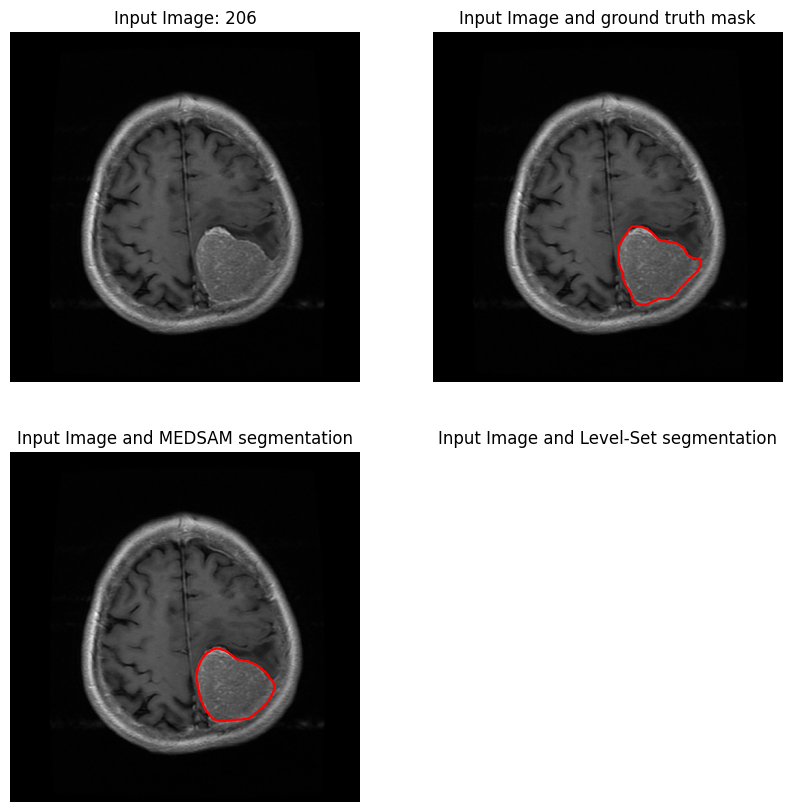

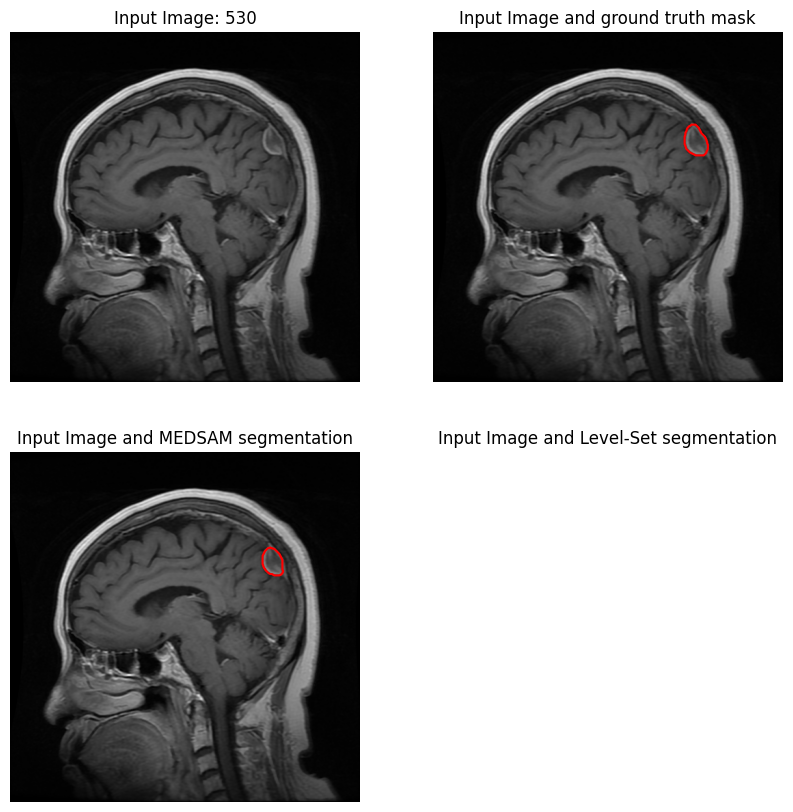

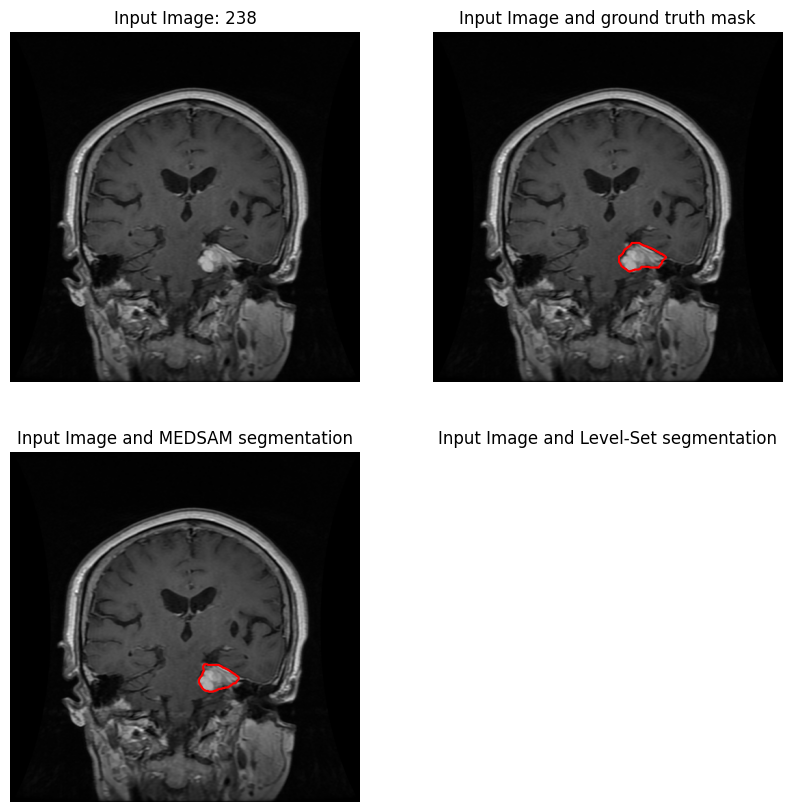

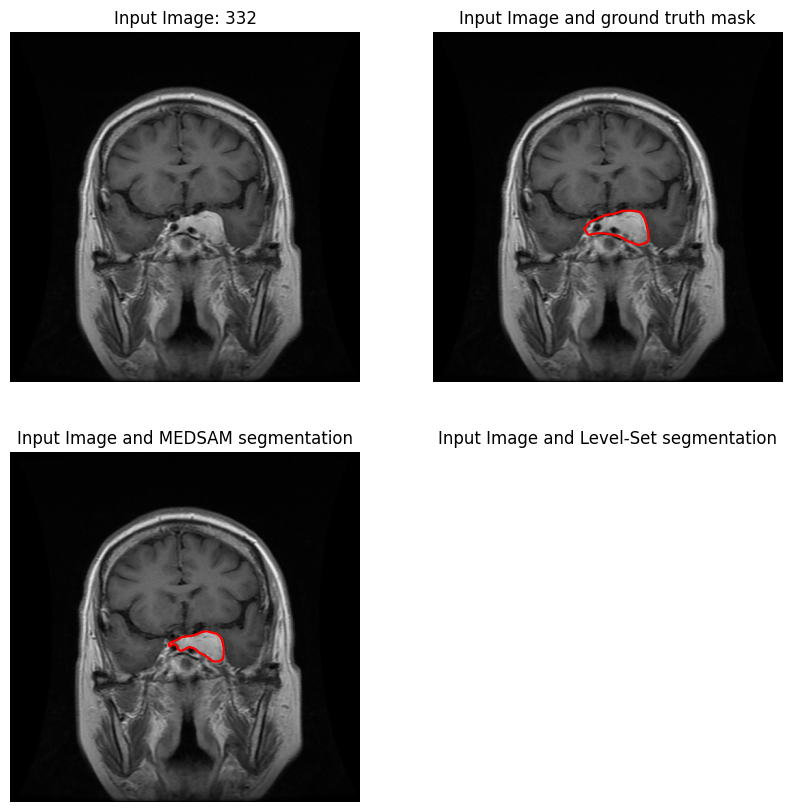

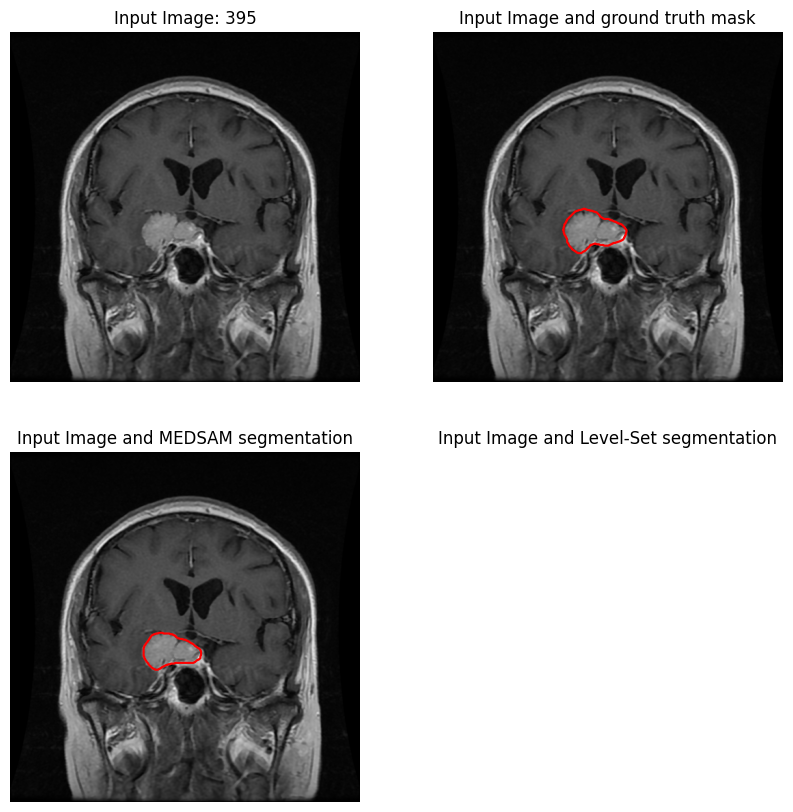

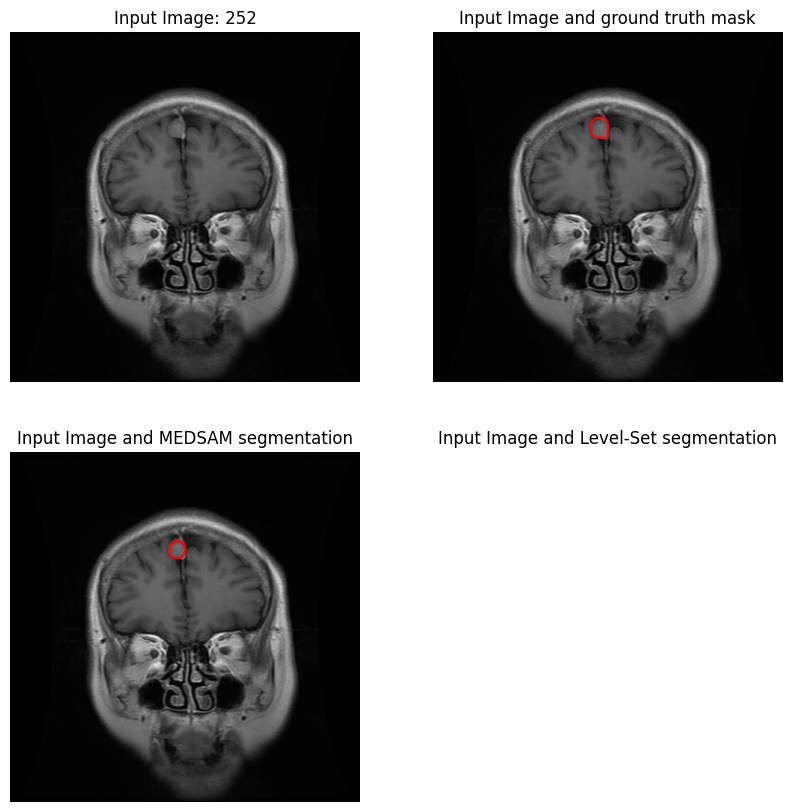

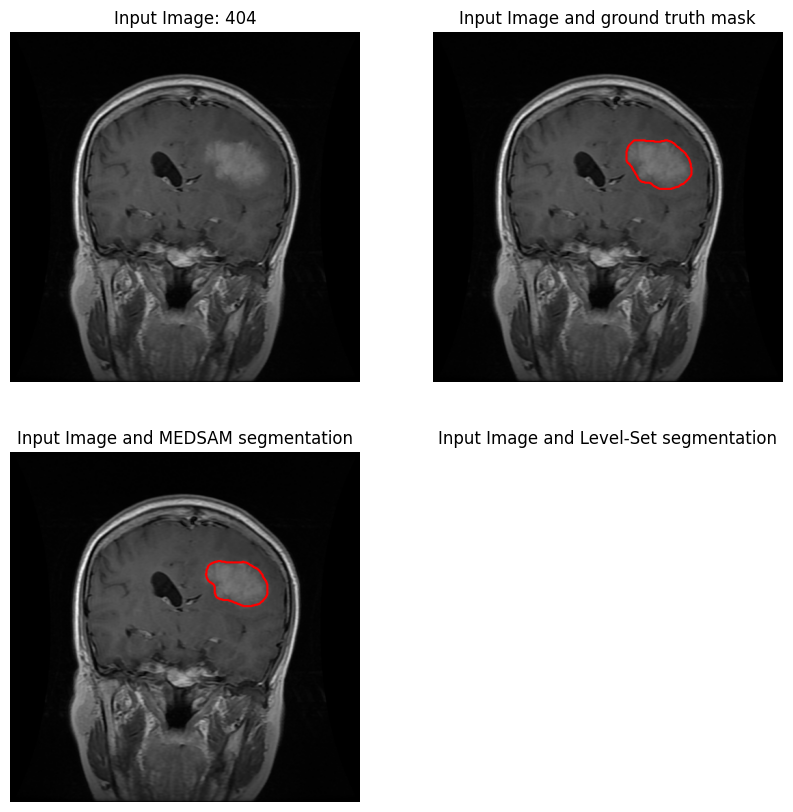

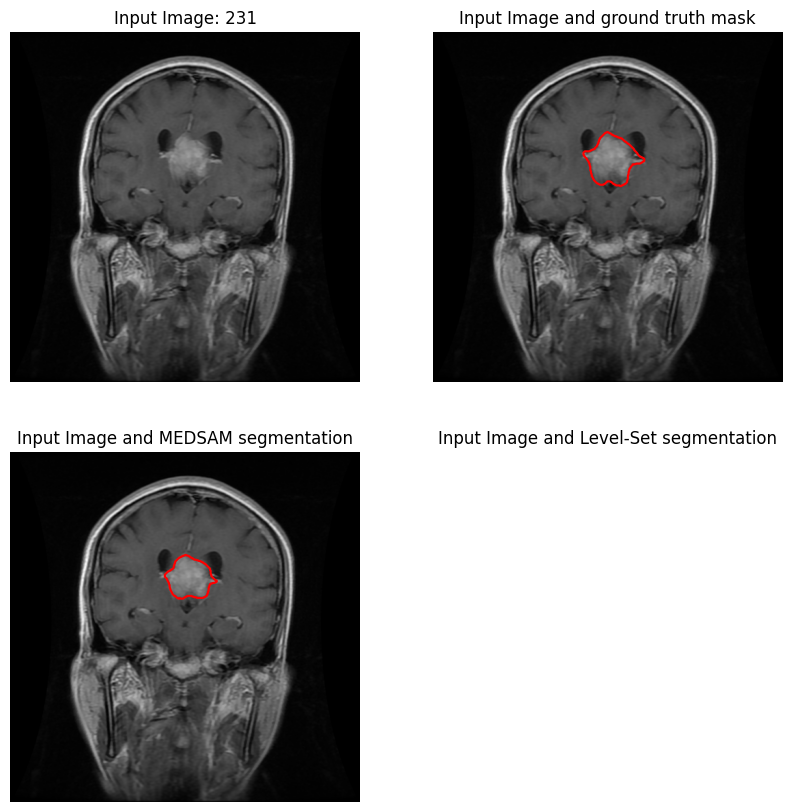

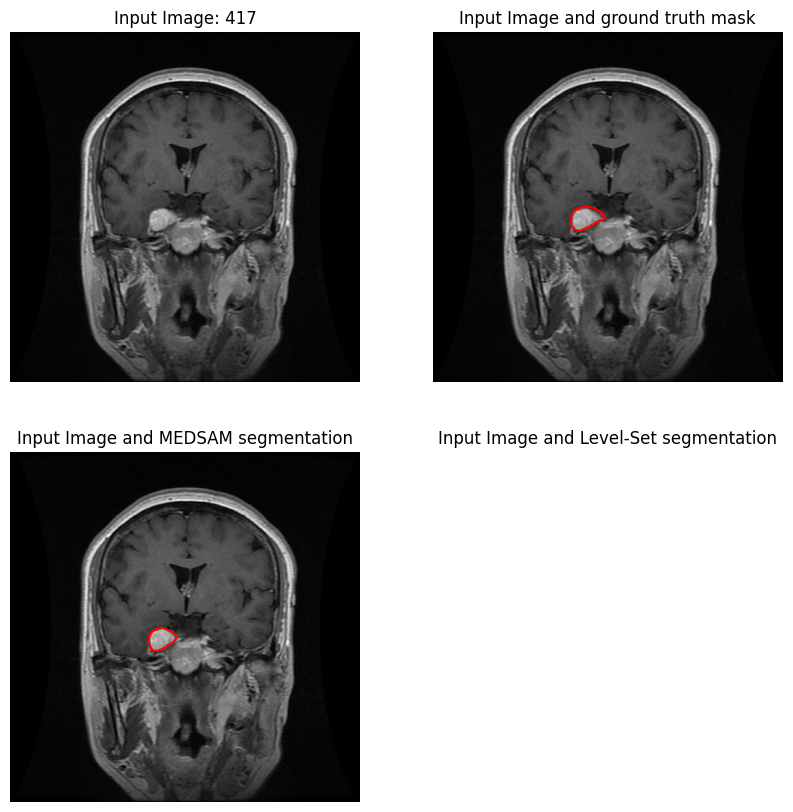

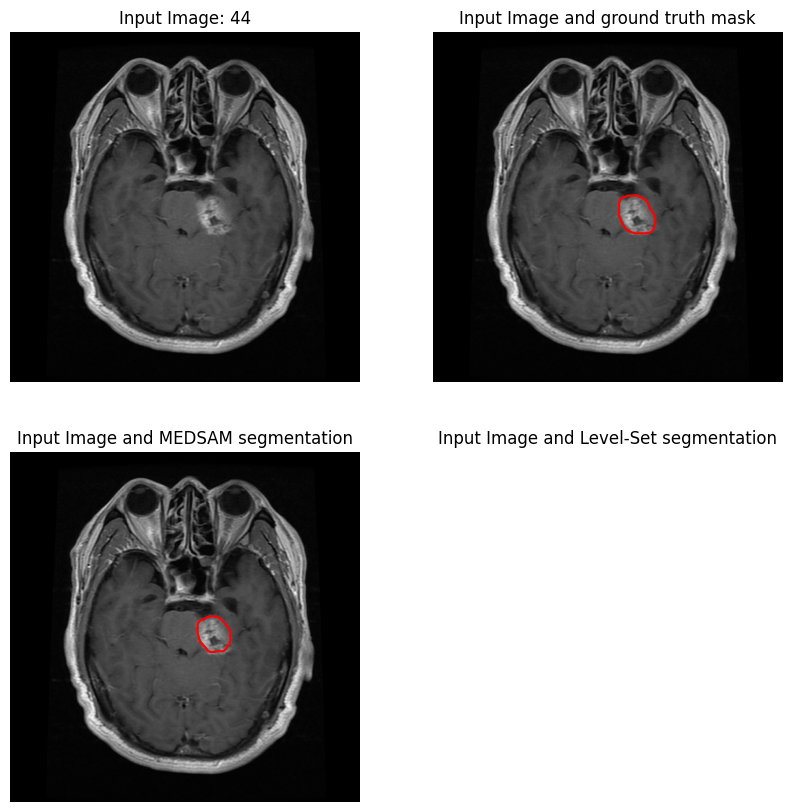

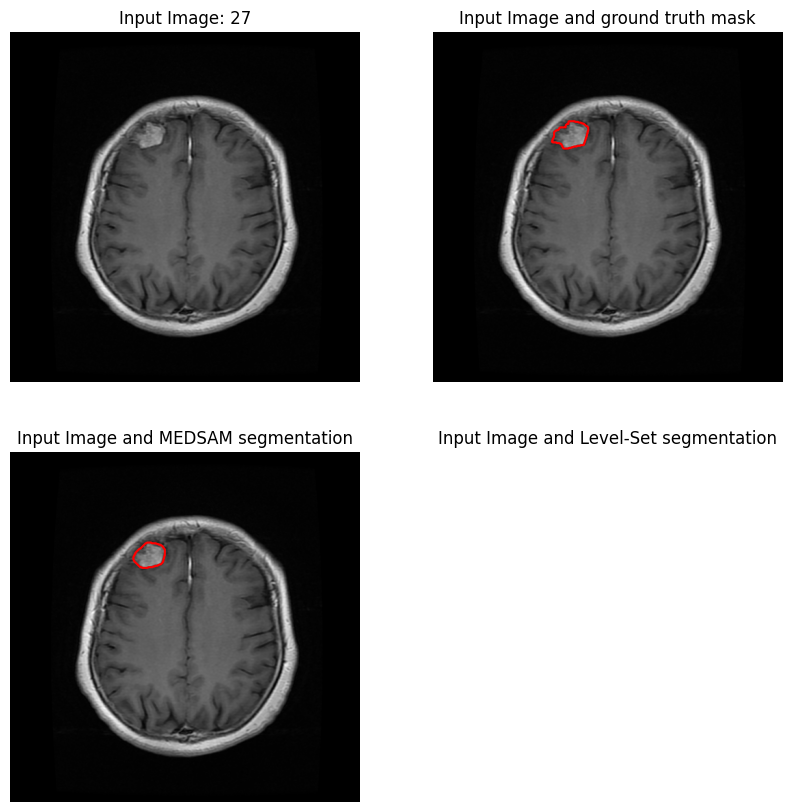

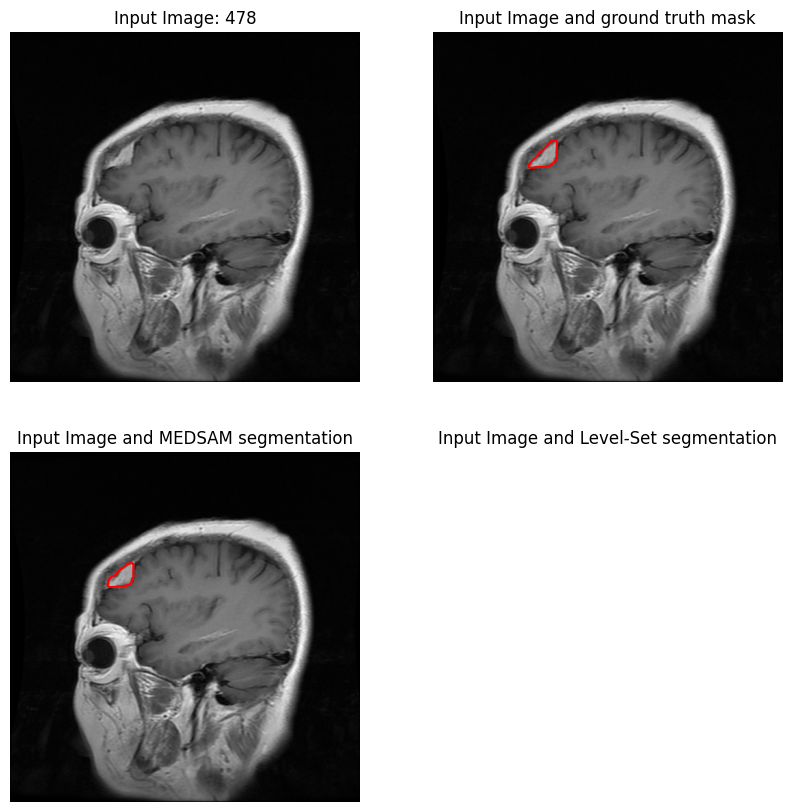

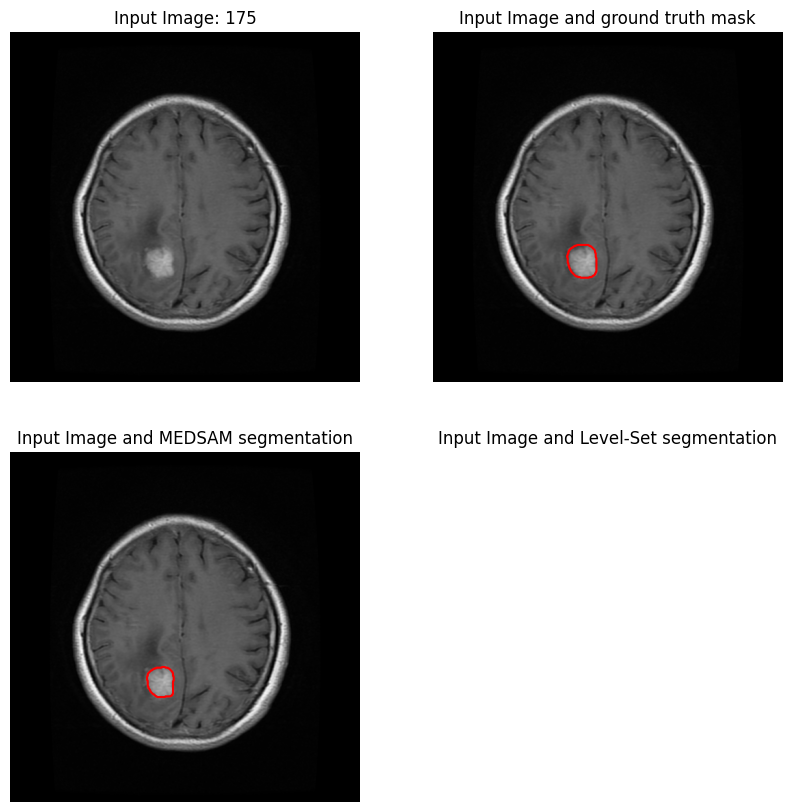

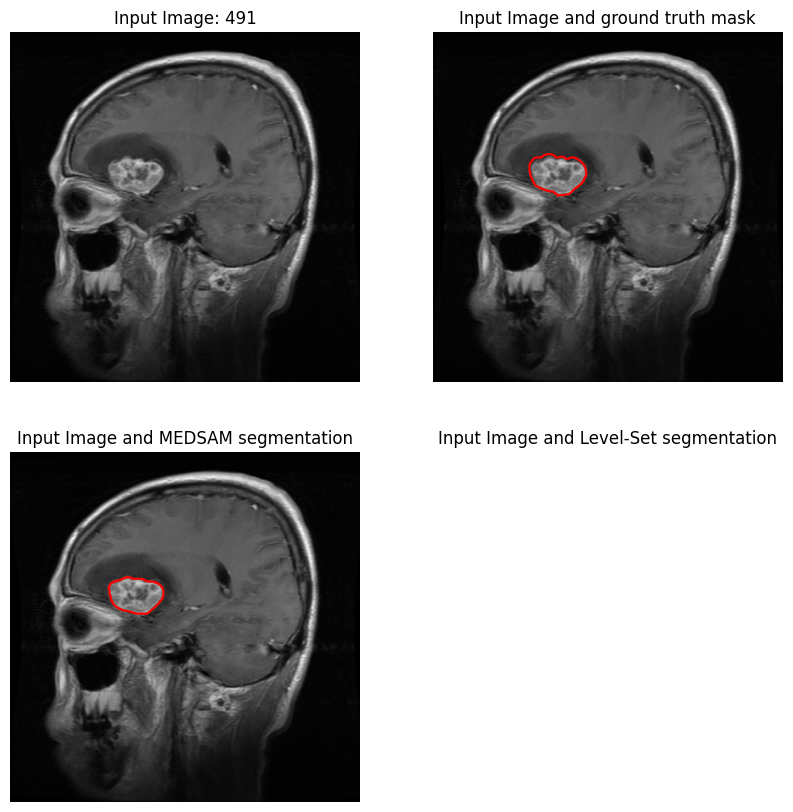

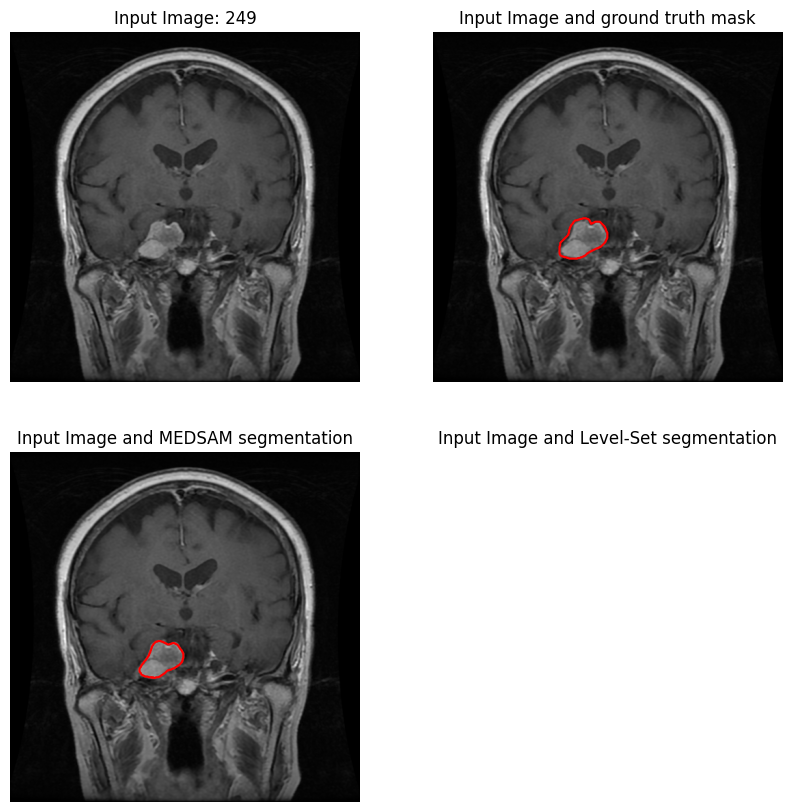

In [ ]:
model.eval()
metrics_list = Test(model, test_SAMdataset, processor, threshold=0.7)
#for k,v in metrics_list.items:
 # print(f'{k}: {mean(v)}')

test for my self

In [ ]:
for i in range(len(metrics_list['id'])):
  print(f"id: {metrics_list['id'][i]}")
  print(f"'F1 Score': {metrics_list['F1 Score'][i]}, 'Jaccard Index': {metrics_list['Jaccard Index'][i]}, 'Recall': {metrics_list['Recall'][i]}, 'Precision':  {metrics_list['Precision'][i]}, 'Accuracy': {metrics_list['Accuracy'][i]}")
  print('\n')

id: 206
'F1 Score': 0.955873859304609, 'Jaccard Index': 0.9154773758159088, 'Recall': 0.942697653223969, 'Precision':  0.9694236176194939, 'Accuracy': 0.9970855712890625


id: 530
'F1 Score': 0.8988307066598882, 'Jaccard Index': 0.8162511542012927, 'Recall': 0.8162511542012927, 'Precision':  1.0, 'Accuracy': 0.9992408752441406


id: 238
'F1 Score': 0.8733072524826964, 'Jaccard Index': 0.7751068376068376, 'Recall': 0.8088071348940914, 'Precision':  0.9489862655330281, 'Accuracy': 0.9983940124511719


id: 332
'F1 Score': 0.7845046570702794, 'Jaccard Index': 0.6454197143852316, 'Recall': 0.6454197143852316, 'Precision':  1.0, 'Accuracy': 0.9961166381835938


id: 395
'F1 Score': 0.8946038352906199, 'Jaccard Index': 0.8093060785368478, 'Recall': 0.8095238095238095, 'Precision':  0.9996677740863787, 'Accuracy': 0.9972953796386719


id: 252
'F1 Score': 0.815609756097561, 'Jaccard Index': 0.6886326194398682, 'Recall': 0.7013422818791947, 'Precision':  0.9743589743589743, 'Accuracy': 0.99927902

In [ ]:
from statistics import mean
for k,v in metrics_list.items():
  if k != 'id':
    print(f"'{k}': {mean(v)}")

'F1 Score': 0.8889608728342525
'Jaccard Index': 0.8025709842810633
'Recall': 0.811861732813093
'Precision': 0.9867077994878143
'Accuracy': 0.9981188456217448
